<a href="https://colab.research.google.com/github/rezzie-rich/colab-notebooks/blob/main/Mistral_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

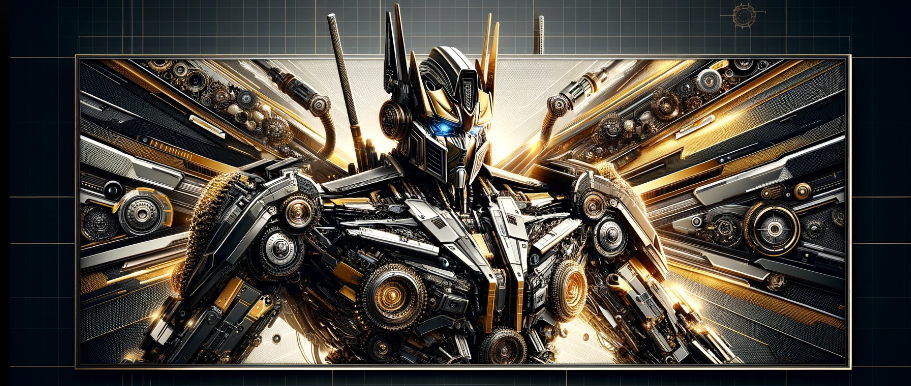

# Repair Bay: The Comprehensive Solution for Expert Language Model Training and Enhancement 📚🛠️

🌟 Welcome to the Future of AI Training 🌟

Embark on a journey of seamless and efficient machine learning with our cutting-edge training script. Designed to empower both beginners and experienced AI enthusiasts, this script is your gateway to training sophisticated language models like Mistral 7B with ease. Experience the blend of user-friendly interaction, advanced model support, and smart data handling, all while ensuring robust performance enhancements. Whether you're looking to fine-tune your AI model or embark on new machine learning adventures, this script is the perfect tool to elevate your AI journey.

Dive into the features that make this script a standout choice:


🚀 Automated Machine Learning: Streamlines the training of large language models with minimal manual intervention.

👩‍💻 User-Friendly Interaction: Easily input settings and preferences through simple interactive prompts.

🌐 Support for Large Models: Optimized for complex models like Mistral 7B, catering to advanced AI tasks.

🛠️ Performance Enhancement Techniques:

LoRA: Efficient model tuning with fewer parameters.
PEFT: Effective training process for distributed systems.
💾 Regular Checkpoints: Automatically saves the model's progress at regular intervals, ensuring no loss of significant training advancements.

🔍 Robust Error Handling: Vigilant checks and balances to maintain smooth operation and handle unexpected situations gracefully.

📊 Versatile Data Management: Adaptability to load and process datasets from various sources, enhancing flexibility.

In [ ]:
# Install necessary libraries
!pip install -q transformers datasets bitsandbytes-cuda11 peft huggingface_hub optuna pandas trl

In [ ]:
# Modularized and Dynamic Training Script for Mistral 7B with LoRA and PEFT

import logging
import pandas as pd
import torch
from transformers import (AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments, DataCollatorForSeq2Seq, trainer_utils)
from datasets import load_dataset, Dataset
from peft import LoraConfig, prepare_model_for_int8_training, get_peft_model
from sklearn.model_selection import train_test_split
from huggingface_hub import notebook_login

# Authenticate with Hugging Face
notebook_login()

# Setting up logging for debugging and tracking
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Custom Callback for Checkpointing during training
class CustomCheckpointCallback(trainer_utils.Callback):
    def __init__(self, model):
        self.model = model

    def on_step_end(self, args, state, control, **kwargs):
        # Save model at every 100 steps for tracking and potential rollback
        if state.global_step % 100 == 0:
            self.model.save_pretrained(f'{args.output_dir}/checkpoint_{state.global_step}')

# Function Definitions

def input_with_validation(prompt, type_=None, validation=None, error_msg='Invalid input'):
    """Validates and converts user input."""
    while True:
        try:
            value = input(prompt)
            if type_:
                value = type_(value)
            if validation and not validation(value):
                raise ValueError
            return value
        except ValueError:
            print(error_msg)

def initialize_model_and_tokenizer(model_name):
    """Initializes the model and tokenizer."""
    try:
        model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        return model, tokenizer
    except Exception as e:
        logging.error(f"Error initializing model and tokenizer: {e}")
        raise

def configure_lora(model, r, lora_alpha, target_modules, lora_dropout, bias_config):
    """
    Configures LoRA for the model. LoRA allows efficient tuning of large language models by
    learning low-rank updates instead of full-rank weight matrices, reducing the number of trainable parameters.
    """
    try:
        lora_config = LoraConfig(r=r, lora_alpha=lora_alpha, target_modules=target_modules, lora_dropout=lora_dropout, bias=bias_config)
        # Preparing model for quantized INT8 training for efficiency
        model = prepare_model_for_int8_training(model)
        # Applying PEFT for efficient distributed training
        model = get_peft_model(model, lora_config)
        return model
    except Exception as e:
        logging.error(f"Error configuring LoRA: {e}")
        raise

def load_and_prepare_dataset(dataset_name, text_field, response_field=None, local_path=None, tokenizer=None, max_length=512):
    """
    Loads and prepares the dataset. This includes loading the dataset from a local path or from Hugging Face,
    tokenizing the text, and formatting it properly for the model training.
    """
    try:
        if local_path:
            dataset = Dataset.from_pandas(pd.read_csv(local_path))
        else:
            dataset = load_dataset(dataset_name, split='train')

        def preprocess_function(examples):
            if response_field:
                text = ['Prompt: ' + ex[text_field] + '\nResponse: ' + ex[response_field] for ex in examples]
            else:
                text = examples[text_field]
            return tokenizer(text, truncation=True, padding='max_length', max_length=max_length)

        dataset = dataset.map(preprocess_function, batched=True)
        return dataset
    except Exception as e:
        logging.error(f"Error loading and preparing dataset: {e}")
        raise

def train_model(model, training_args, train_dataset, test_dataset, tokenizer):
    """
    Trains the model with the provided datasets. Uses Trainer from Hugging Face for simplicity and efficiency.
    Custom checkpoints are used for saving the model at regular intervals.
    """
    try:
        data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, label_pad_token_id=-100, pad_to_multiple_of=8)
        trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset, data_collator=data_collator, callbacks=[CustomCheckpointCallback(model)])
        trainer.train()
    except Exception as e:
        logging.error(f"Error during model training: {e}")
        raise

# Main Script Execution
def main():
    try:
        # Model and tokenizer initialization
        model_name = input("Enter the model name (e.g., 'mistralai/Mistral-7B-v0.1'): ")
        model, tokenizer = initialize_model_and_tokenizer(model_name)

        # Configuring LoRA parameters
        # LoRA rank and alpha values should be tuned based on the specific model and training data
        r = input_with_validation("Enter LoRA rank (e.g., 16): ", int)
        lora_alpha = input_with_validation("Enter LoRA alpha (e.g., 32): ", int)
        target_modules = input("Enter target modules separated by comma (e.g., 'q_proj,k_proj,v_proj,o_proj'): ").split(',')
        lora_dropout = input_with_validation("Enter LoRA dropout rate (e.g., 0.05): ", float)
        bias_config = input("Enter bias configuration ('none' or other): ")
        model = configure_lora(model, r, lora_alpha, target_modules, lora_dropout, bias_config)

        # Training arguments setup
        learning_rate = input_with_validation("Enter learning rate (e.g., 1e-3): ", float)
        num_train_epochs = input_with_validation("Enter number of training epochs (e.g., 5): ", int)
        batch_size = input_with_validation("Enter per device train batch size (e.g., 8): ", int)
        output_dir = input("Enter output directory path: ")
        training_args = TrainingArguments(output_dir=output_dir, learning_rate=learning_rate, num_train_epochs=num_train_epochs, per_device_train_batch_size=batch_size, logging_steps=50, save_steps=100, fp16=True, gradient_checkpointing=True, evaluation_strategy="epoch", warmup_steps=500, weight_decay=0.01, lr_scheduler_type="linear")

        # Dataset loading and preparation
        dataset_name = input("Enter the dataset name (leave blank if using local dataset): ")
        text_field = input("Enter the name of the text field in the dataset: ")
        response_field = input("Enter the name of the response field in the dataset (leave blank if not applicable): ")
        local_path = input("Enter local dataset path (leave blank if using Hugging Face dataset): ")
        dataset = load_and_prepare_dataset(dataset_name, text_field, response_field, local_path, tokenizer)

        # Splitting the dataset into training and testing sets
        train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

        # Starting the training process
        train_model(model, training_args, train_dataset, test_dataset, tokenizer)

        # Uploading the trained model to Hugging Face for easy access and version control
        model.push_to_hub(f"{model_name}_trained_model")
    except Exception as e:
        logging.error(f"An error occurred in the main script: {e}")

if __name__ == "__main__":
    main()


🌟 Embracing the Future with Repair Bay - A Symphony of AI Excellence 🌟

As we gracefully conclude our journey with the Repair Bay script, let's take a moment to reflect on this masterpiece of technology. It's not just a script; it's a beacon of innovation in the vast ocean of AI training.

🚀 Interactive and Personalized Experience: At the heart of Repair Bay lies its interactive soul. With each prompt and input, the script dances to the rhythm of your commands, tailoring the training experience to your unique vision.

🌐 Mastery Over Majestic Models: Navigating the complexities of giants like Mistral 7B, Repair Bay stands tall, harnessing their power with an ease that belies the sophistication beneath.

🛠️ Technological Harmony: LoRA and PEFT come together in a beautiful symphony, optimizing your model's learning journey. It's a delicate balance of strength and efficiency, crafted with the precision of a maestro.

💾 Checkpoint Chronicles: Each checkpoint is a story, a moment captured in the tapestry of training. These regular snapshots are not just data; they're lifelines to your model's evolving intelligence.

🔍 Vigilant Guardian: With its robust error handling, Repair Bay watches over your training with an eagle's eye, ensuring smooth sailing through the sometimes turbulent seas of machine learning.

📊 A Conductor of Data: Whether orchestrating local datasets or harmonizing cloud-based sources, Repair Bay adapts with grace, making every type of data sing in perfect tune with your training needs.

⚙️ Performance and Elegance Unified: This script is a testament to the elegance of efficiency. Every line of code, every algorithmic decision, is a step towards a future where AI training is not just powerful, but also an art form.

In essence, Repair Bay is a celebration of what's possible in the realm of AI and machine learning. It's a tool, a companion, and a gateway to a future where every ambitious AI dream can be realized with elegance and precision.

Repair Bay: Where AI training becomes an expressive journey, and every user a maestro of their own AI destiny. 🎓🌌